In [1]:
!pip install pandas matplotlib tensorflow

     |████████████████████████████████| 462 kB 13.8 MB/s 


In [2]:
import pandas as pd
df = pd.read_csv("Tweets.csv")

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
rev = df[["text","airline_sentiment"]]
rev.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [6]:
rev.shape

(14640, 2)

In [7]:
# removing neutral reviews
rev = rev[rev["airline_sentiment"] != "neutral"]
rev.head()

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [8]:
rev.shape

(11541, 2)

In [10]:
rev["airline_sentiment"].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [15]:
def typefinder(x):
  if x == "positive":
    return 0
  else:
    return 1
rev["airline_sentiment"] = rev["airline_sentiment"].map(typefinder)

In [16]:
rev

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,0
3,@VirginAmerica it's really aggressive to blast...,1
4,@VirginAmerica and it's a really big bad thing...,1
5,@VirginAmerica seriously would pay $30 a fligh...,1
6,"@VirginAmerica yes, nearly every time I fly VX...",0
...,...,...
14633,@AmericanAir my flight was Cancelled Flightled...,1
14634,@AmericanAir right on cue with the delays👌,1
14635,@AmericanAir thank you we got on a different f...,0
14636,@AmericanAir leaving over 20 minutes Late Flig...,1


In [18]:
tweet = rev.text.values

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
token = Tokenizer(num_words = 5000)
token.fit_on_texts(tweet) 

In [21]:
encoded = token.texts_to_sequences(tweet)

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
padded = pad_sequences(encoded, maxlen = 200)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

In [34]:
embedding_vector_length = 32
vocab_size = len(token.word_index) + 1
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics= ["accuracy"])

print(model.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 32)           423488    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
________________________________________________

In [38]:
res = model.fit(padded,rev.airline_sentiment, validation_split = 0.2, epochs =5, batch_size = 32)

Epoch 1/5
289/289 [==============================] - 49s 160ms/step - loss: 0.3971 - accuracy: 0.8342 - val_loss: 0.2090 - val_accuracy: 0.9203
Epoch 2/5
289/289 [==============================] - 47s 162ms/step - loss: 0.2231 - accuracy: 0.9146 - val_loss: 0.1663 - val_accuracy: 0.9385
Epoch 3/5
289/289 [==============================] - 46s 160ms/step - loss: 0.1654 - accuracy: 0.9390 - val_loss: 0.1683 - val_accuracy: 0.9420
Epoch 4/5
289/289 [==============================] - 46s 160ms/step - loss: 0.1307 - accuracy: 0.9530 - val_loss: 0.1620 - val_accuracy: 0.9450
Epoch 5/5
289/289 [==============================] - 46s 160ms/step - loss: 0.1105 - accuracy: 0.9588 - val_loss: 0.1818 - val_accuracy: 0.9424


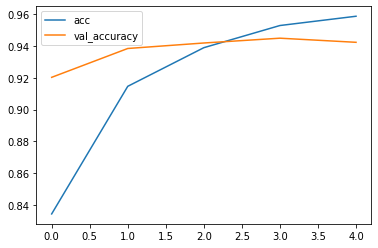

In [42]:
import matplotlib.pyplot as plt
plt.plot(res.history["accuracy"], label= "acc")
plt.plot(res.history["val_accuracy"], label = "val_accuracy")
plt.legend()
plt.show()



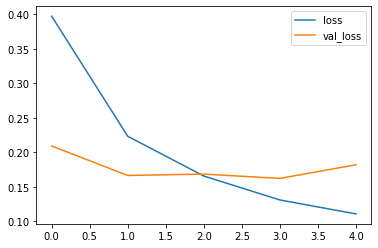

In [43]:
plt.plot(res.history["loss"], label= "loss")
plt.plot(res.history["val_loss"], label = "val_loss")
plt.legend()
plt.show()

In [50]:
def predicting(text):
  tw = token.texts_to_sequences([text])
  tw = pad_sequences(tw, maxlen = 200)
  prediction = int(model.predict(tw).round().item())
  print("prediction is", "positive" if prediction == 0 else "negtive")

test1 = "I enjoyed my trip very much, thank you so much for such a good flight"
predicting(test1)
test2 = "Never booking my trip again with them shit service no food no water, absolutely bad service"
predicting(test2)

prediction is positive
prediction is negtive
